# Hyperspectral image analysis

I  this assignment we're gonna analyze a multispectral image, looking for patterns in the data. 
The image is given in tif format, and a list of corresponding wavelengths is provided separately. 

Let's start by loading the wavelength data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from libtiff import TIFF
import cv2
from skimage.io import imread
import skimage
import pickle

plt.rcParams["figure.figsize"] = [15, 5]

# Load wavelengths
wavs = pd.read_csv("data/wavs.csv", header=None)

wavs = wavs.melt(value_name="wlength", var_name="chan").set_index("chan")
print(
    f"Found {len(wavs)} frequencies, from {min(wavs.wlength)} to {max(wavs.wlength)}"
)
wlist = list(wavs["wlength"])

Found 41 frequencies, from 475 to 875


A typical human eye will respond to wavelengths from about 380 to 700 nanometers, so these wavelengths are the ones included in the visible spectrum, plus some IR.

![Light spectrum](quality-of-a-light-source.jpg)

In [2]:
wavs.diff()["wlength"].value_counts()

10.0    40
Name: wlength, dtype: int64

The wavelength values are equally spatiated. 

It's time to load the image(s).

In [3]:
# Load tif image
data = Path("data") / "dataToExplore.tif"
tiff = TIFF.open(data, mode="r")
image = tiff.read_image()
image.shape

(2001, 1601, 41)

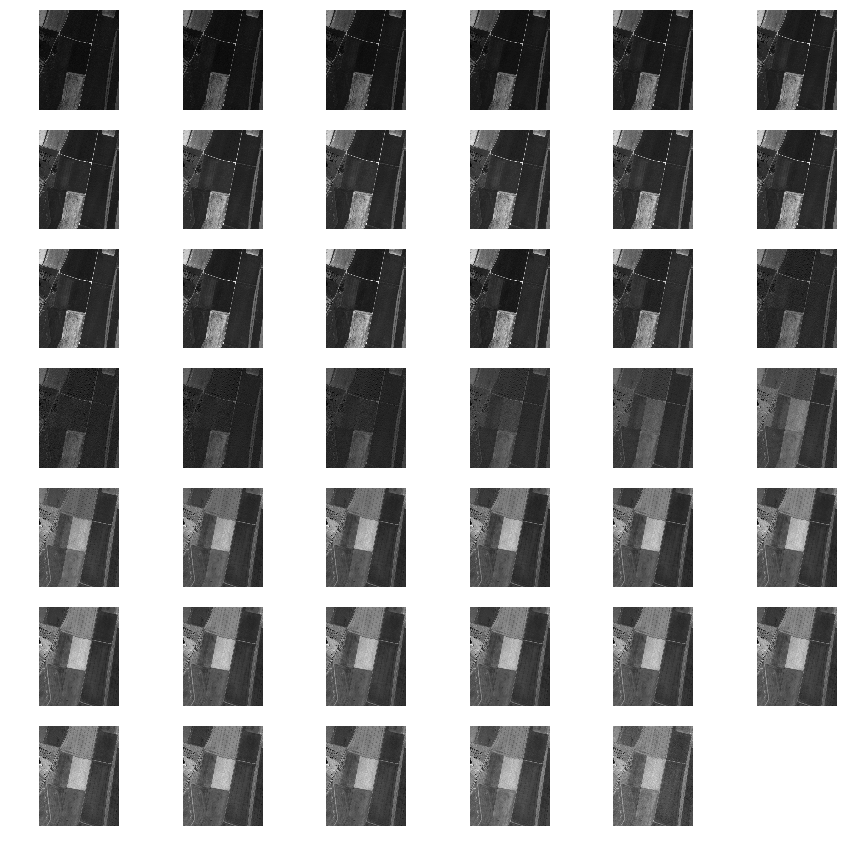

In [4]:
fig = plt.figure(1, figsize=(15, 15))

for i in range(41):
    ax = fig.add_subplot(7, 6, i + 1)
    ax.imshow(image[:, :, i], cmap="gray")
    ax.set_axis_off()

Depending on the wavelength, it looks like that some of the features are more visible than others.

In [5]:
def plot_histogram(img, ax=None, legend=True):
    if not ax:
        _, ax = plt.subplots(1, 1)
    ax.hist(img.flatten(), 255, [1, 255], alpha=0.5, label=f"channel {i}")
    if not legend:
        ax.legend().set_visible(False)


layers = cv2.split(image)

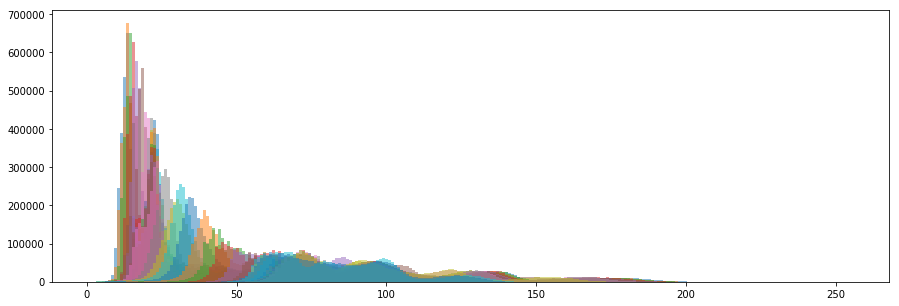

In [6]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
for l in layers:
    plot_histogram(l, ax)

There's far too much information in this histogram, but it shows a separation betweeen layers with darker and lighter layers. 

We will try to accentuate this by eliminating the 20th percentile from each tail, and see what happens.

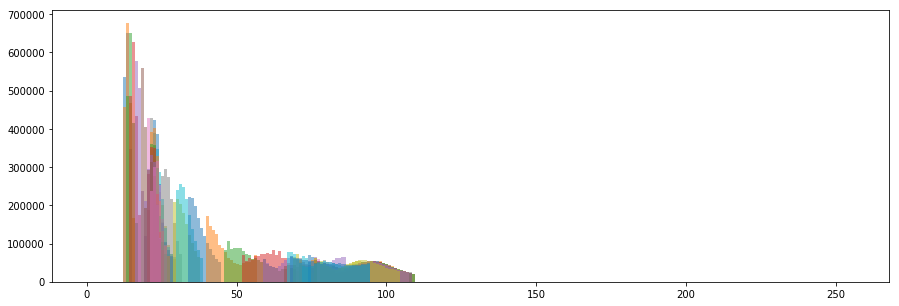

In [7]:
# Extract 20-80 percentile for each layer
def extract_percentile(l, low, high):
    lp, hp = np.percentile(l.ravel(), (low, high))
    l[l < lp] = 0
    l[l > hp] = 0
    return l


_, ax = plt.subplots(1, 1, figsize=(15, 5))
layers = cv2.split(image)
percentiles = []
for l in layers:
    l = extract_percentile(l, 30, 70)
    percentiles.append(l)
    plot_histogram(l, ax)

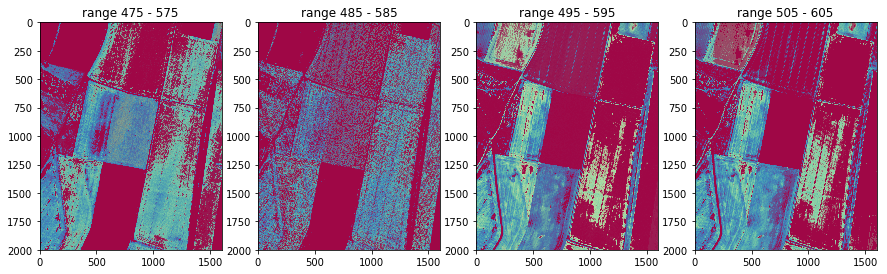

In [8]:
_, axs = plt.subplots(1, 4, figsize=(15, 15))

for i, l in enumerate(percentiles[:-1]):
    ax = axs[i // 10]
    ax.imshow(l, alpha=0.3, cmap="Spectral")
    if i % 10 == 0:
        axs[i // 10].set_title(f"range {wlist[i//10]} - {wlist[i//10 + 10]}")

Visual inspection of the different bands shows that different features can be extracted in the different wavelengths, especially for frequencies below 575 Hz, between 485-585 and higher than 505.

That's not so impressive actually, it's just a complicated way to say that the image contains different colors.

We can do better, but first we need to convert the data to lan format, in order to read it with a library that supports multispectral images. By doing that, we will also downsize the image, because my old notebook has its difficulties running clusterization algorithms with large images.

In [9]:
# Convert image to geotif format, and rescale to 600*400 px approx.
# NOTE: you need to have gdal installed for this to work

!gdal_translate -outsize 600 0 -of LAN "data/dataToExplore.tif" "data/data.lan"

Input file size is 1601, 2001
0...10...20...30...40...50...60...70...80...90...100 - done.


We can now load the image with Spectral Python

ImageView object:
  Display bands       :  [0, 20, 40]
  Interpolation       :  <default>
  RGB data limits     :
    R: [5.0, 99.0]
    G: [-109.0, 108.0]
    B: [-128.0, 127.0]

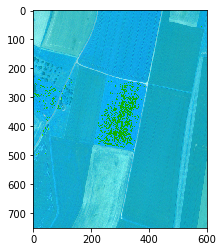

In [10]:
import spectral as spy

simg = spy.open_image("data/data.lan")
spy.imshow(simg)

The image doesn't look very natural. We'll try to have a better representation by identifying three channels for RGB.

In [11]:
# Define a dictionary for mapping wavelengths with layers
wtoi = {wl: i for i, wl in enumerate(wlist)}

ImageView object:
  Display bands       :  (15, 6, 1)
  Interpolation       :  <default>
  RGB data limits     :
    R: [3.0, 109.0]
    G: [8.0, 91.0]
    B: [5.0, 96.0]

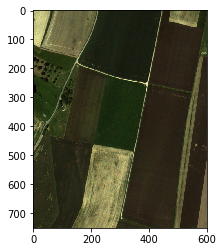

In [12]:
# Red spectrum should be between 620-750 nm,
# Green between 495-570 nm and
# Blue between 450-495

red, green, blue = wtoi[625], wtoi[535], wtoi[485]

spy.imshow(simg, (red, green, blue))

It looks better now!

We will try to run kmeans to classify the different areas of the image based on the values on each layer (different wavelengths).

But since the algorithm is computationally expensive, we're gonna reduce the dimensions of the image with PCA. 

In [13]:
pc = spy.principal_components(simg)

Covariance.....  0.0Covariance.....  0.0Covariance.....  1.0Covariance.....  2.0Covariance.....  3.0Covariance.....  4.0Covariance.....  5.0Covariance.....  6.0Covariance.....  7.0Covariance.....  8.0Covariance.....  9.0Covariance..... 10.0Covariance..... 11.0Covariance..... 12.0Covariance..... 13.0Covariance..... 14.0Covariance..... 15.0Covariance..... 16.0Covariance..... 17.0Covariance..... 18.0Covariance..... 19.0Covariance..... 20.0Covariance..... 21.0Covariance..... 22.0Covariance..... 23.0Covariance..... 24.0Covariance..... 25.0Covariance..... 26.0Covariance..... 27.0Covariance..... 28.0Covariance..... 29.0Covariance..... 30.0Covariance..... 31.0Covariance..... 32.0Covariance..... 33.0Covariance..... 34.0Covariance..... 35.0Covariance..... 36.0Covariance..... 37.0Covariance..... 38.0Covariance..... 39.0Covariance..... 40.0Covariance..... 41.0Covariance..... 42.0Covariance..... 43.0Covariance..... 44.0Covariance..... 45.0Covariance..... 46.0Covariance..... 47.0Covariance..... 48.0

To reduce dimensionality without losing too much information, we will eliminate progressively less important components (eigenvalues) until reaching the threshold of the 99% of the total image variance. 

We then reduce the dimensionality by projecting the original pixels onto the remaining eigenvectors. 

In [14]:
# Total number of eigenvalues (and eigenvectors)
len(pc.eigenvalues)

41

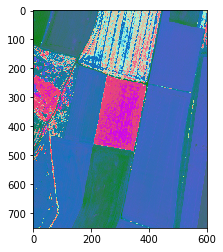

In [15]:
# Exclude until 99% of variance explained
pc_99 = pc.reduce(fraction=0.99)

# And transform original image
simg_pc = pc_99.transform(simg)

_ = spy.imshow(simg_pc[:, :, :3], stretch_all=True)

In [16]:
simg_pc.shape

(750, 600, 16)

We were able to compress the image to 41 layers to the 16 layers, losing just 1% of the variance.

We can now proceed with Kmeans, looking for 4 clusters.

_Note: since the algorithm takes a life to run, I precalculated the clusters' centers and load them while starting the algorithm_

In [17]:
# load optimized cluster centers
with open("2.1.5.centers.pkl", "rb") as fp:
    _centers = pickle.load(fp)

In [18]:
# Usig just 5 iterations, since the centers are already optimized
_maps, _centers = spy.kmeans(
    simg, nclusters=4, max_iterations=5  # start_clusters=_centers
)

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  0.Iteration 1...  1.Iteration 1...  1.Iteration 1...  1.Iteration 1...  1.Iteration 1...  1.Iteration 1...  1.Iteration 1...  1.Iteration 1...  2.Iteration 1...  2.Iteration 1...  2.Iteration 1...  2.Iteration 1...  2.Iteration 1...  2.Iteration 1...  2.Iteration 1...  2.Iteration 1...  3.Iteration 1...  3.Iteration 1...  3.Iteration 1...  3.Iteration 1...  3.Iteration 1...  3.Iteration 1...  3.Iteration 1...  4.Iteration 1...  4.Iteration 1...  4.Iteration 1...  4.Iteration 1...  4.Iteration 1...  4.Iteration 1...  4.Iteration 1...  4.Iteration 1...  5.Iteration 1...  5.Iteration 1...  5.Iteration 1...  5.Iteration 1...  5.Iteration 1...  5.Iteration 1...  5.Iteration 1...  6.Iteration 1...  6.Iteration 1...  6.Iteration 1...  6.Iteration 1...  6.Iteration 1...

In [19]:
pickle.dump(_centers, open("2.1.5.centers.pkl", "wb"))

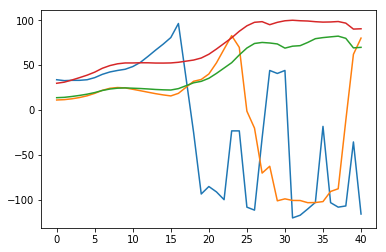

In [20]:
# Plot kmeans cluster centers for each layer

_, ax = plt.subplots(1, 1)
for i in range(_centers.shape[0]):
    ax.plot(_centers[i])

Finally, we can plot the clusters overlayed on the original image to check the correspondance with image features.

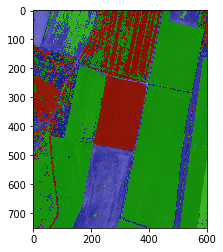

In [21]:
view = spy.imshow(simg, (red, green, blue), classes=_maps)
view.set_display_mode("overlay")
view.class_alpha = 0.5

### Check for vegetation using the The Normalized Difference Vegetation Index (NDVI)

The Normalized Difference Vegetation Index (NDVI) is an indicator of the presence of vegetation. It works by comparing IR and NIR radiation. The index is commonly defined as

    $NDVI = \frac{NIR-RED}{NIR+RED}$

where NIR is the reflectance in the near infrared (NIR) part of the spectrum and RED is the reflectance of the red band. the index varies between -1 and 1, with higher values meaning vegetation.

    RED band ~= 620–750 nm

    NIR band ~= 750-1400 nm

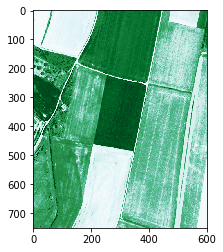

In [22]:
from skimage.exposure import equalize_hist

red = wtoi[625]
nir = wtoi[755]
ndvi = spy.ndvi(simg, red, nir)

plt.imshow(equalize_hist(np.squeeze(ndvi)), cmap="BuGn")